In [1]:
using PyPlot, Printf, DelimitedFiles, JuliennedArrays, Pipe

In [2]:
include("decode.jl")
include("utils.jl")

include("UpdateRule.jl")
include("Leaky.jl")
include("VarSMiLe.jl")
include("ParticleFiltering.jl")

include("inference.jl")
include("readData.jl")
include("regression.jl");

In [3]:
function plotMEG(surprises, megs, ols, params)
    fig = figure(figsize=(3,3.5))
    # set title and labels
    # title(@sprintf("%s using update rule %s, m = %i", params["title"], params["rule"], params["m"]))
    xlabel("Surprise (bits)")
    ylabel("MEG activity (pT)")
    grid(true)
    
    scale = 1e12
    
    # plot points
    @inbounds for i = eachindex(surprises)
        scatter(surprises[i], scale * megs[i], s=1, label="block $i")
    end
    
    # plot regression line
    coefs = coef(ols)
    points = map(length, megs)
    intercept = sum(coefs[1:end-1] .* points) / sum(points)
    
    X = reduce(vcat, surprises)
    yhat = coefs[end] * X .+ intercept
    
    r2val = @sprintf("%.3f %%", 100 * r2(ols))
    plot(X, scale * yhat, "k", label="linear regression, r2 = $r2val")

    #legend()
end;

## Regression

In [27]:
# load subject data
sub13 = loadJLD2(getJLD2Filename(13));

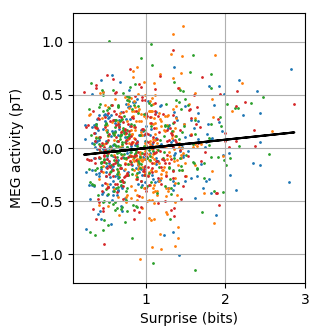

In [97]:
m = 1
rule = Leaky(10, true)

# define initial params
alpha_0 = ones(2, 2^m)

# define which data we look at
subject = sub13
sensor = 13 # in range [1, 306] 37, 211, 198
time = 201 # in range [1, 321] 120, 127, 126

# perform regression
surprises, megs, ols, y = regression(subject, sensor, time, rule, m, alpha_0)

# plot surprises
infos = Dict(
    "title"   => "MEG activity (pT)", 
    "m"       => m,
    "sensor"  => sensor,
    "rule"    => rule.str
)
plotMEG(surprises, megs, ols, infos)
;

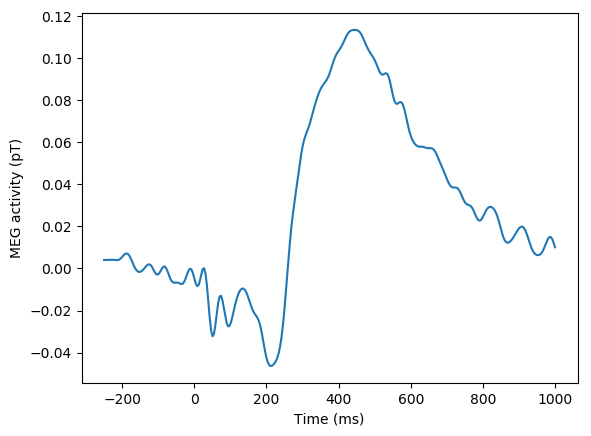

In [85]:
timecourse(idx, sensor) = @pipe idx |> getJLD2Filename |> loadJLD2 |> avg.(_.meg, sensor) |> mean
avg(data, sensor) = @pipe mean(data[:,sensor,:], dims=1) |> dropdims(_, dims=1)

subjects = 1:3
sensor = 13

dt = timecourse.(subjects, sensor) |> mean

plot(range(-250, 1000, length=321), 1e12 * dt)
ylabel("MEG activity (pT)")
xlabel("Time (ms)")
xlim([-270, 1020])
ylim([-0.05, 0.12])
#plot([531, 531], [-1, 1], "k")
;

## Maximum $R^2$

In [4]:
function export_maxr2(seq, filename)
    f = open("ckpt/$filename", "w")

    for el in seq
        print(f, el)
        print(f, " ")
    end
    
    close(f)
end

function import_maxr2(filename)
    f = open("ckpt/$filename", "r")
    t = readdlm(f)
    close(f)
    
    return t[1,1:321]
end
;

In [5]:
function computeR2(X::Array{Float64,2}, y::Array{Float64,1})
    return r2(fit(LinearModel, X, y)) # r2(lm(@formula(Y ~ X), DataFrame(X=X, Y=y)))
end

function mapMaxR2(subject, models, subjectIdx = 1, onehotencode_blocks = false, verbose = 2)   
    surprises, megs = mapSubject(subject, models, onehotencode_blocks, verbose)
    surprises = surprises[1] # we are only testing one model (but multiple params)
    
    if verbose > 1
        lg("mapMaxR2: computing r2...")
    end
    
    # map to r2
    r2s = zeros(size(surprises,1), size(megs,2), size(megs,3))
    for i in CartesianIndices(r2s)
        r2s[i] = computeR2(surprises[i[1]], megs[:,i[2],i[3]])
    end
    
    # max for each sensor
    r2s = @pipe findmax(r2s, dims=1) |> dropdims(_[1], dims=1)
    
    # average across sensors
    r2s = @pipe mean(r2s, dims=1) |> dropdims(_, dims=1)
    
    # save in ckpt folder
    # filename = "max_r2_subject_$subjectIdx.txt"
    # export_maxr2(r2s, filename)
    
    return r2s
end

function mapmaxr2_inference(subject, models, subjectidx = 1, onehotencode_blocks = false, verbose = 2)   
    surprises, megs = mapsubject_inference(subject, models, onehotencode_blocks, verbose)
    
    # surprises is (n_models, n_rules_per_model, surprises) (in array form)
    # we need to cat so we get (n_models x n_rules_per_model, surprises)
    surprises = vcat(surprises...)
    
    verbose > 1 && lg("mapmaxr2_inference: computing r2...")
    
    # map to r2
    r2s = zeros(size(surprises,1), size(megs,2), size(megs,3))
    for i in CartesianIndices(r2s)
        r2s[i] = computeR2(surprises[i[1]], megs[:,i[2],i[3]])
    end
    
    # max for each sensor
    r2s = @pipe findmax(r2s, dims=1) |> dropdims(_[1], dims=1)
    
    # average across sensors
    r2s = @pipe mean(r2s, dims=1) |> dropdims(_, dims=1)
    
    # save in ckpt folder
    filename = "max_r2_subject_$subjectidx.txt"
    export_maxr2(r2s, filename)
    
    return r2s
end
;

In [6]:
function maxR2AcrossSubjects(subjects, models, onehotencode_blocks = false, verbose = 1)
    nTimesteps = 321
    maxR2List = zeros(length(subjects), nTimesteps)
    t = zeros(nTimesteps)
    
    for subIdx in eachindex(subjects)
        subName = subjects[subIdx]
        if verbose > 0
            lg("Loading data for subject $subName...")
        end
        
        # load subject
        sub = loadJLD2(getJLD2Filename(subName))
        
        if subIdx == 1
            t = sub.time
        end
        
        # compute r2 timecourse
        filename = "max_r2_subject_$subName.txt"
        if isfile("ckpt/$filename")
            @inbounds maxR2List[subIdx,:] = import_maxr2(filename)
        else
            @inbounds maxR2List[subIdx,:] = mapMaxR2(sub, models, subName, onehotencode_blocks, verbose)
        end
    end
    
    # average across subjects
    maxR2_ = @pipe mean(maxR2List, dims=1) |> dropdims(_, dims=1)
    
    # export data
    #dt = Dates.format(now(), "dd-mm-HH-MM")
    #export_maxr2(maxR2_, "max_r2_$dt.txt")
    
    return t, maxR2_, maxR2List
end

function maxr2_inference(subjects, models, onehotencode_blocks = false, verbose = 1)
    timesteps = 321
    maxr2 = zeros(length(subjects), timesteps)
    t = range(-250, stop=1000, length=timesteps) |> collect
    
    for subidx in eachindex(subjects)
        subname = subjects[subidx]
        verbose > 0 && lg("Loading data for subject $subname...")
        
        # compute r2 timecourse
        filename = "max_r2_subject_$subname.txt"
        if isfile("ckpt/$filename")
            @inbounds maxr2[subidx,:] = import_maxr2(filename)
        else
            subdata = loadJLD2(getJLD2Filename(subname))
            @inbounds maxr2[subidx,:] = mapmaxr2_inference(subdata, models, subname, onehotencode_blocks, verbose)
        end
    end
    
    # average across subjects
    maxr2_avg = @pipe mean(maxr2, dims=1) |> dropdims(_, dims=1)
    
    return t, maxr2_avg, maxr2
end

function maxR2AcrossSubjectsFromCkpt(subjects)
    nTimesteps = 321
    maxR2List = zeros(length(subjects), nTimesteps)
    
    for subIdx in eachindex(subjects)
        subject = subjects[subIdx]
        maxR2List[subIdx,:] = importmaxr2("max_r2_subject_$subject.txt")
    end
    
    # average across subjects
    maxR2_ = @pipe mean(maxR2List, dims=1) |> dropdims(_, dims=1)
    t = range(-250, stop = 1000, length = length(maxR2_)) |> collect
    
    return t, maxR2_, maxR2List
end
;

In [7]:
function plot_best_r2(t, maxr2_avg, maxr2)
    N = size(maxr2,1) # number of subjects
    maxr2_std = @pipe std(maxr2, dims = 1) |> dropdims(_, dims=1) ./ sqrt(N)
    maxr2_min = maxr2_avg - maxr2_std
    maxr2_max = maxr2_avg + maxr2_std;
    
    figure(figsize=[10,5])
    
    plot(t, 100 * maxr2_avg, "k", lw=2)
    fill_between(t, 100 * maxr2_min, 100 * maxr2_max, color="0.75", alpha=0.5)
    
    xlabel("Time (ms)")
    ylabel("Explained variance (%)")
    grid("on")
    #legend()
end
;

## VarSMiLe

In [ ]:
ms = vcat(log2range(0, 10, 55))
ms = ms / findmax(ms)[1] * exp(-1)
varsmile_rules = build_rules_varsmile(ms)
varsmile_models = build_models(varsmile_rules, [0,1])
varsmile_models = [vcat(varsmile_models...)]

# subjects
subjects = 1:18

# get max r2
t, maxR2_, maxR2List = maxR2AcrossSubjects(subjects, varsmile_models);

[2020-04-25T17:20:21.964] Loading data for subject 1...


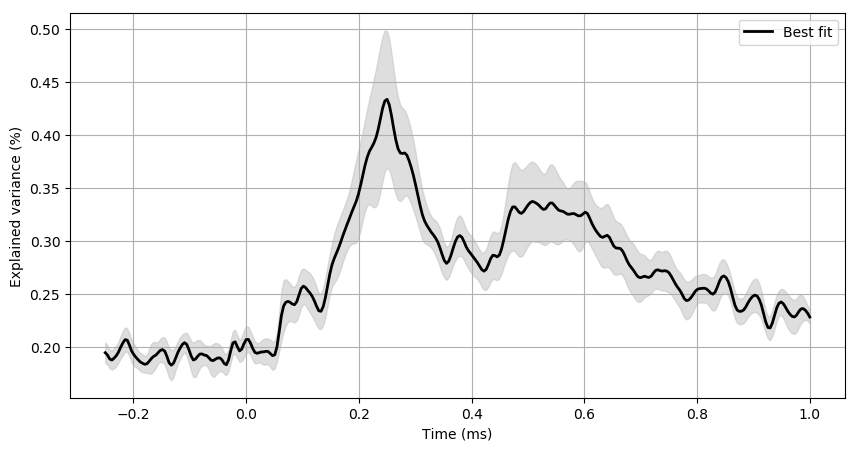

C:\Users\antho\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [9]:
plot_best_r2(t, maxR2_, maxR2List);

## Leaky, $m \in [0, 1, 2]$

In [21]:
m_values = [0,1,2]

ws = vcat(log2range(0, 10, 54), [Inf])
leaky_rules = build_rules_leaky(ws)
leaky_models = build_models(leaky_rules, m_values)
leaky_models = [vcat(leaky_models...)]

# subjects
subjects = 1:18
;

In [ ]:
# get max r2
t, maxR2Leaky, maxR2LeakyList = maxR2AcrossSubjects(subjects, leaky_models, true)
;

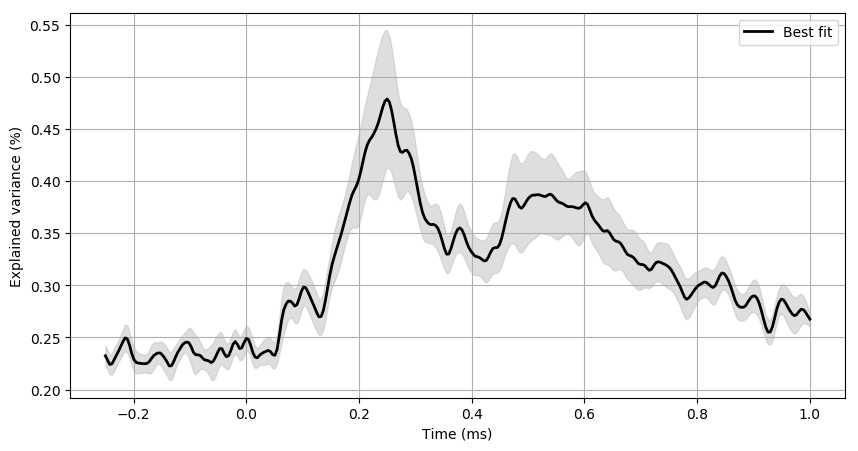

C:\Users\antho\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [24]:
plot_best_r2(t, maxR2Leaky, maxR2LeakyList);

## Leaky, $m \in [0, 1]$

In [ ]:
ws = vcat(log2range(0, 10, 54), [Inf])
leaky_rules = build_rules_leaky(ws)
leaky_models = build_models(leaky_rules, [0,1])
leaky_models = [vcat(leaky_models...)]

# subjects
subjects = 1:18

# get max r2
t, maxR2_, maxR2List = maxR2AcrossSubjects(subjects, leaky_models);

In [8]:
t, maxR2_, maxR2List = maxR2AcrossSubjectsFromCkpt(1:18);

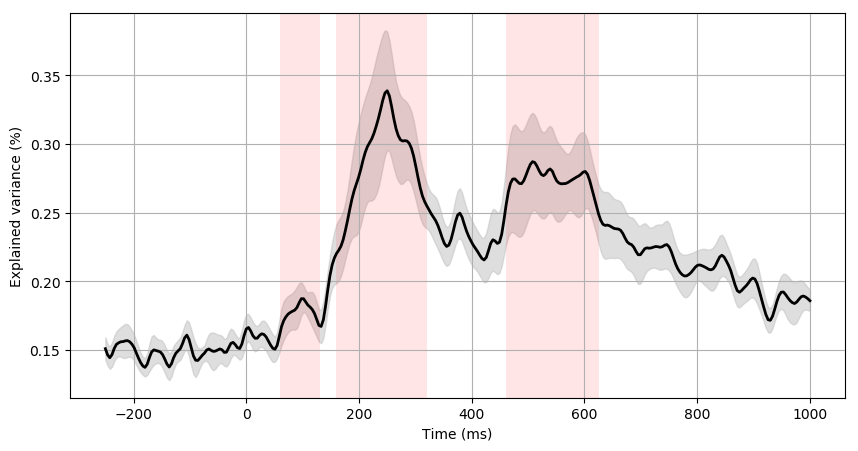

In [23]:
plot_best_r2(t, maxR2_, maxR2List)

ax = gca()
slices = [[60, 130], [160, 320], [460, 625]]

for slice in slices
    x = slice[1]
    w = slice[2] - slice[1]
    rect = matplotlib.patches.Rectangle((x, 0), w, 1, linewidth=1, facecolor=(1,0,0,0.1))
    ax.add_patch(rect)
end

## Leaky with inference, $m \in [0, 1, 2]$

In [ ]:
ws = vcat(log2range(0, 10, 54), [Inf])
prior = prior_uniform(2)
leaky_rules = build_rules_leaky_inference(ws)
leaky_models = [map(
        rule -> Dict("rule" => rule, "prior" => copy(prior)),
        leaky_rules
)]

# subjects
subjects = 1:18

# get max r2
t, maxr2_avg, maxr2 = maxr2_inference(subjects, leaky_models, true);

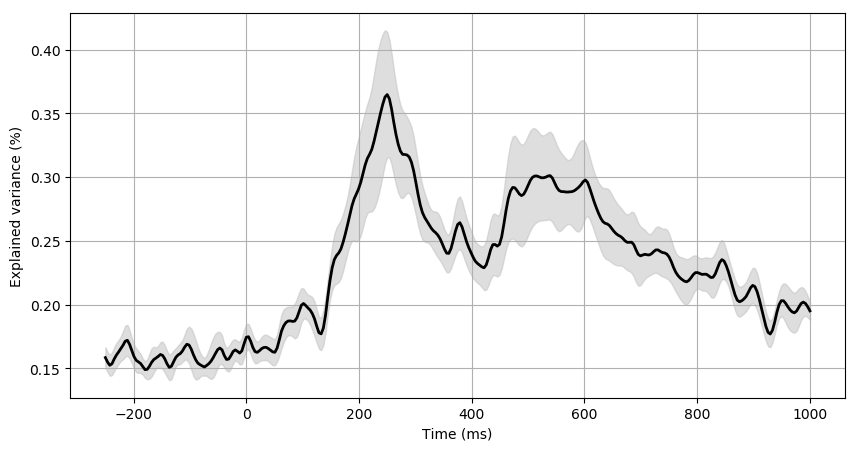

In [35]:
# do not keep block level
t, maxr2_avg, maxr2 = maxr2_inference(subjects, leaky_models, true, 0);
plot_best_r2(t, maxr2_avg, maxr2);

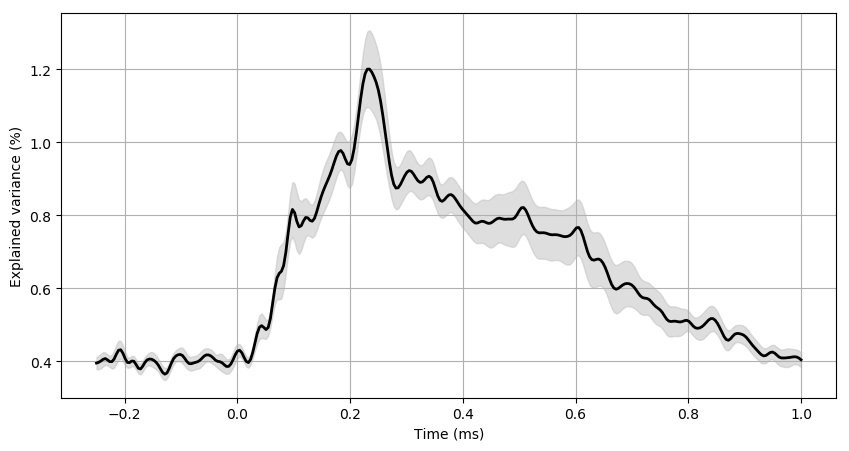

In [32]:
# keep block level
plot_best_r2(t, maxr2_avg, maxr2);

## Trial 1

[2020-04-14T17:48:17.574] MODE 4

[2020-04-14T17:48:24.176] Loading data for subject 1...
[2020-04-14T17:48:57.853] Loading data for subject 2...
[2020-04-14T17:49:20.617] Loading data for subject 3...
[2020-04-14T17:49:41.202] Loading data for subject 4...
[2020-04-14T17:50:02.254] Loading data for subject 5...
[2020-04-14T17:50:23.676] Loading data for subject 6...
[2020-04-14T17:50:44.866] Loading data for subject 7...
[2020-04-14T17:51:06.41] Loading data for subject 8...
[2020-04-14T17:51:27.25] Loading data for subject 9...
[2020-04-14T17:51:46.824] Loading data for subject 10...
[2020-04-14T17:52:07.853] Loading data for subject 11...
[2020-04-14T17:52:26.526] Loading data for subject 12...
[2020-04-14T17:52:45.592] Loading data for subject 13...
[2020-04-14T17:53:00.986] Loading data for subject 14...
[2020-04-14T17:53:18.494] Loading data for subject 15...
[2020-04-14T17:53:39.545] Loading data for subject 16...
[2020-04-14T17:53:58.555] Loading data for subject 17...
[2020-04

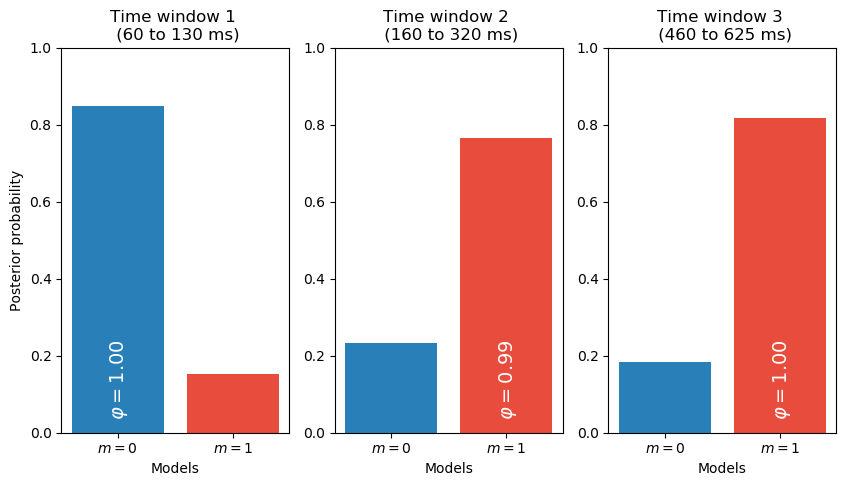

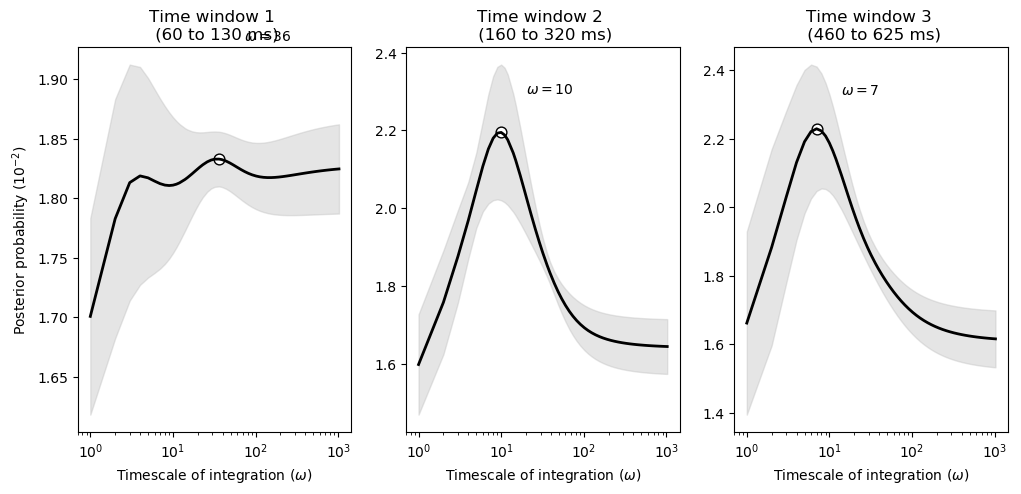



[2020-04-14T17:54:41.141] MODE 5

[2020-04-14T17:54:41.143] Loading data for subject 1...
[2020-04-14T17:55:02.209] Loading data for subject 2...
[2020-04-14T17:55:20.341] Loading data for subject 3...
[2020-04-14T17:55:39.517] Loading data for subject 4...
[2020-04-14T17:56:00.64] Loading data for subject 5...
[2020-04-14T17:56:20.468] Loading data for subject 6...
[2020-04-14T17:56:42.754] Loading data for subject 7...
[2020-04-14T17:57:02.772] Loading data for subject 8...
[2020-04-14T17:57:20.853] Loading data for subject 9...
[2020-04-14T17:57:38.875] Loading data for subject 10...
[2020-04-14T17:57:58.038] Loading data for subject 11...
[2020-04-14T17:58:14.332] Loading data for subject 12...
[2020-04-14T17:58:32.518] Loading data for subject 13...
[2020-04-14T17:58:45.676] Loading data for subject 14...
[2020-04-14T17:59:03.91] Loading data for subject 15...
[2020-04-14T17:59:23.572] Loading data for subject 16...
[2020-04-14T17:59:40.936] Loading data for subject 17...
[2020-

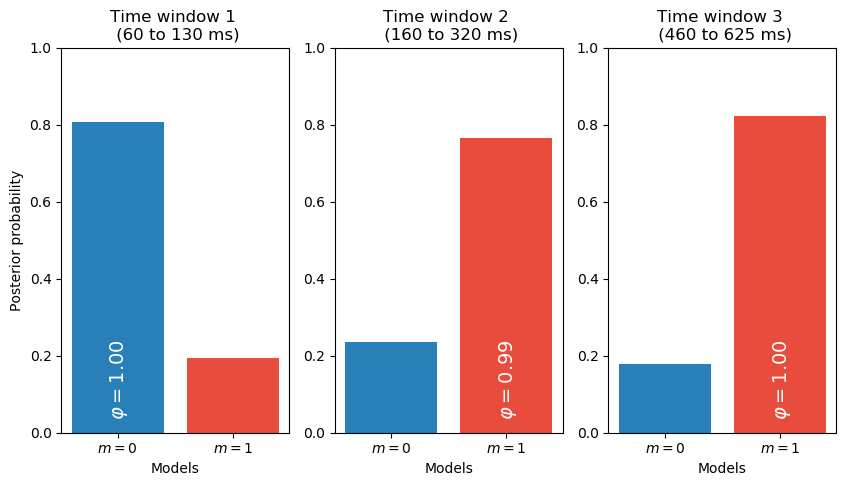

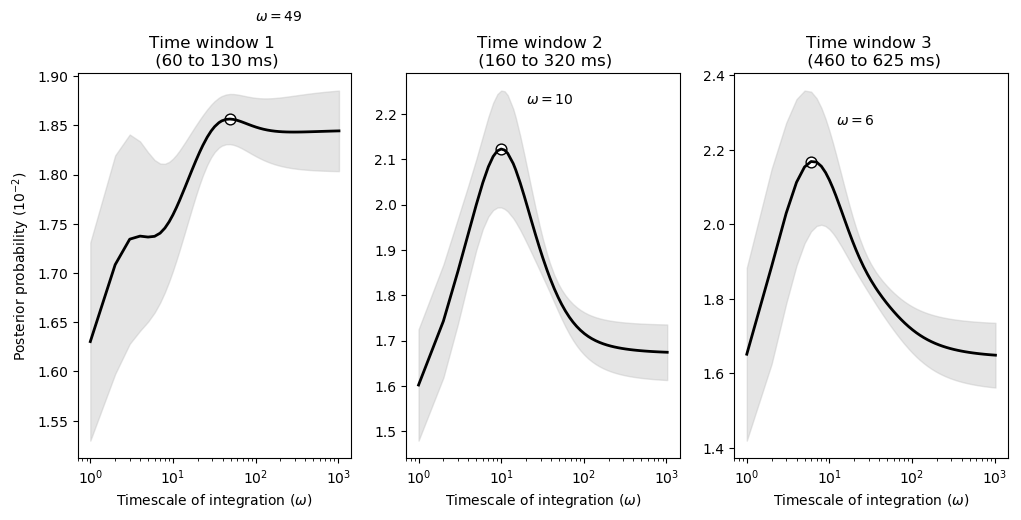



[2020-04-14T18:00:14.898] MODE 6

[2020-04-14T18:00:14.901] Loading data for subject 1...


MethodError: MethodError: objects of type Array{Float64,3} are not callable
Use square brackets [] for indexing an Array.

In [42]:
# TRIAL 1
for mode in modes
    lg("MODE $mode")
    println("")

    wBICs, mBICs = getBICForSubjects(subjects, models, rules, slices, mode, onehotencode_blocks, 1)
    
    fig = fig5D(mBICs, models, sliceNames)
    display(fig)
    clf()
    
    fig = fig5E(ws, wBICs, sliceNames)
    display(fig)
    clf()
    
    println("")
    println("")
end

[2020-04-14T18:08:50.724] MODE 6

[2020-04-14T18:08:50.978] Loading data for subject 1...
[2020-04-14T18:13:50.066] Loading data for subject 2...
[2020-04-14T18:19:33.155] Loading data for subject 3...
[2020-04-14T18:25:57.196] Loading data for subject 4...
[2020-04-14T18:29:34.684] Loading data for subject 5...
[2020-04-14T18:31:32.385] Loading data for subject 6...
[2020-04-14T18:33:29.642] Loading data for subject 7...
[2020-04-14T18:35:31.011] Loading data for subject 8...
[2020-04-14T18:37:07.187] Loading data for subject 9...
[2020-04-14T18:38:33.36] Loading data for subject 10...
[2020-04-14T18:40:17.842] Loading data for subject 11...
[2020-04-14T18:41:34.518] Loading data for subject 12...
[2020-04-14T18:42:57.962] Loading data for subject 13...
[2020-04-14T18:44:07.257] Loading data for subject 14...
[2020-04-14T18:45:31.123] Loading data for subject 15...
[2020-04-14T18:46:57.764] Loading data for subject 16...
[2020-04-14T18:48:24] Loading data for subject 17...
[2020-04-14

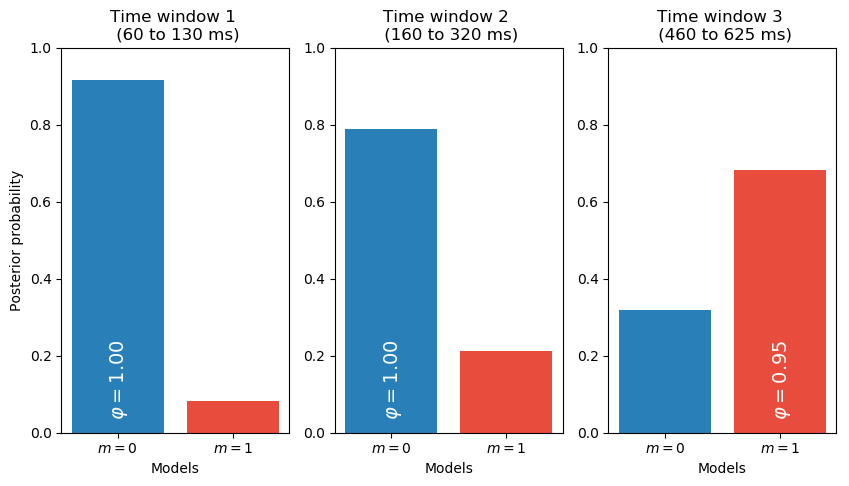

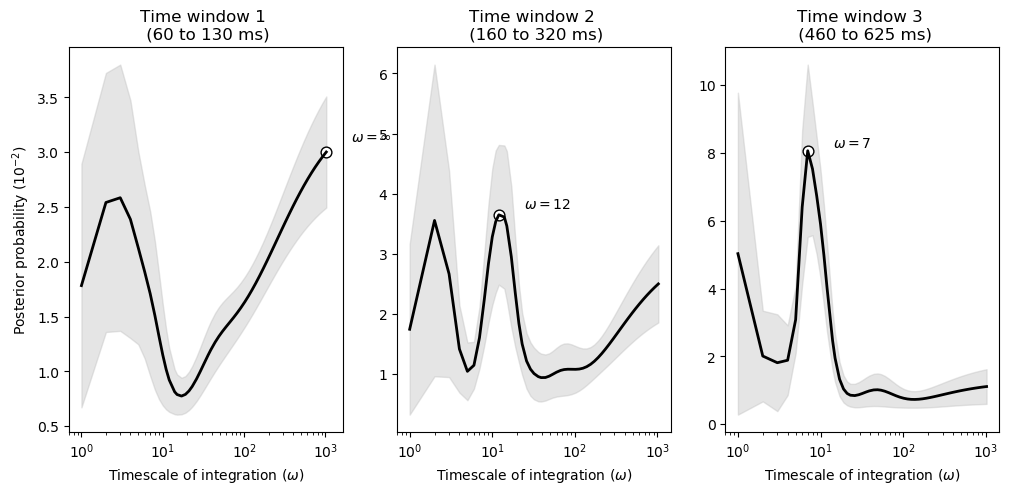



[2020-04-14T18:51:10.218] MODE 7

[2020-04-14T18:51:10.22] Loading data for subject 1...
[2020-04-14T18:52:50.879] Loading data for subject 2...
[2020-04-14T18:54:20.188] Loading data for subject 3...
[2020-04-14T18:56:04.189] Loading data for subject 4...
[2020-04-14T18:58:01.985] Loading data for subject 5...
[2020-04-14T19:00:20.873] Loading data for subject 6...
[2020-04-14T19:02:44.408] Loading data for subject 7...
[2020-04-14T19:04:51.576] Loading data for subject 8...
[2020-04-14T19:06:35.307] Loading data for subject 9...
[2020-04-14T19:08:08.84] Loading data for subject 10...
[2020-04-14T19:10:14.603] Loading data for subject 11...
[2020-04-14T19:11:49.738] Loading data for subject 12...
[2020-04-14T19:13:23.593] Loading data for subject 13...
[2020-04-14T19:14:46.012] Loading data for subject 14...
[2020-04-14T19:16:40.171] Loading data for subject 15...
[2020-04-14T19:18:39.479] Loading data for subject 16...
[2020-04-14T19:20:36.937] Loading data for subject 17...
[2020-

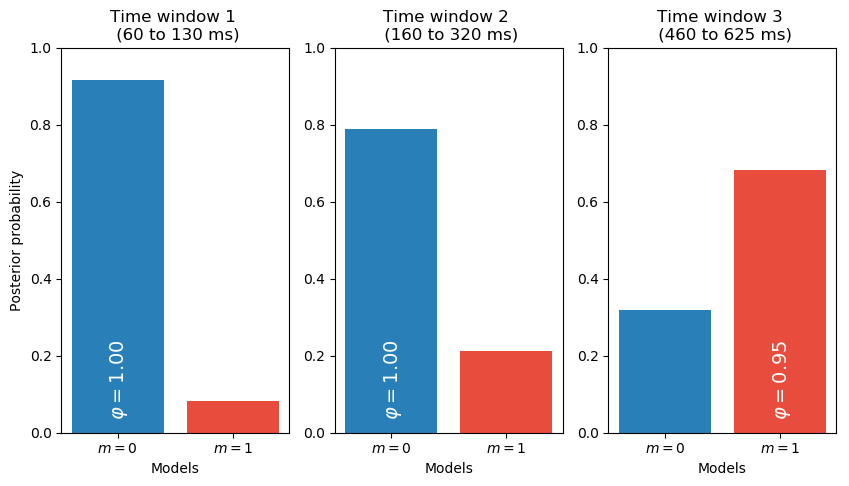

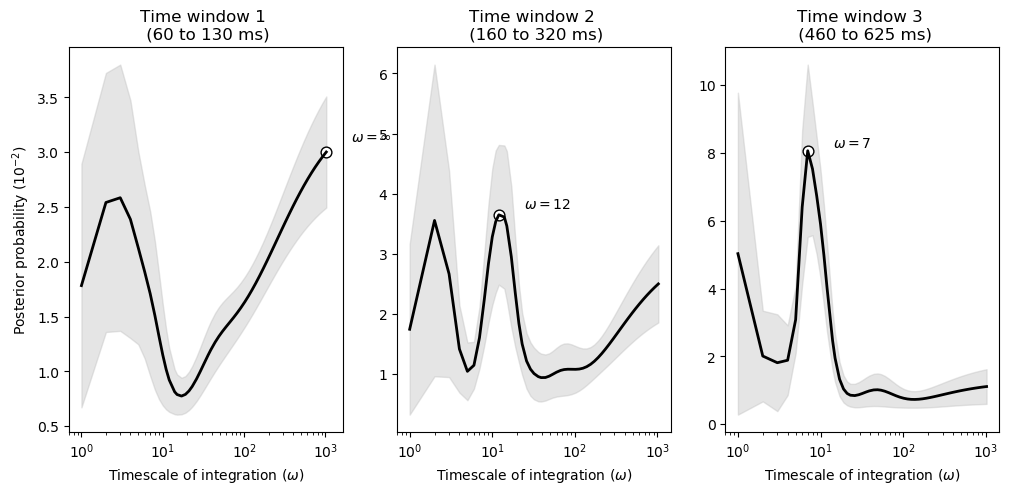



[2020-04-14T19:24:02.002] MODE 8

[2020-04-14T19:24:02.006] Loading data for subject 1...
[2020-04-14T19:26:22.642] Loading data for subject 2...
[2020-04-14T19:28:11.711] Loading data for subject 3...
[2020-04-14T19:29:57.424] Loading data for subject 4...
[2020-04-14T19:32:10.795] Loading data for subject 5...
[2020-04-14T19:33:55.763] Loading data for subject 6...
[2020-04-14T19:35:32.376] Loading data for subject 7...
[2020-04-14T19:37:04.682] Loading data for subject 8...
[2020-04-14T19:38:18.221] Loading data for subject 9...
[2020-04-14T19:39:24.937] Loading data for subject 10...
[2020-04-14T19:40:52.887] Loading data for subject 11...
[2020-04-14T19:41:56.577] Loading data for subject 12...
[2020-04-14T19:43:08.454] Loading data for subject 13...
[2020-04-14T19:44:10.671] Loading data for subject 14...
[2020-04-14T19:45:20.847] Loading data for subject 15...
[2020-04-14T19:46:34.237] Loading data for subject 16...
[2020-04-14T19:47:47.286] Loading data for subject 17...
[202

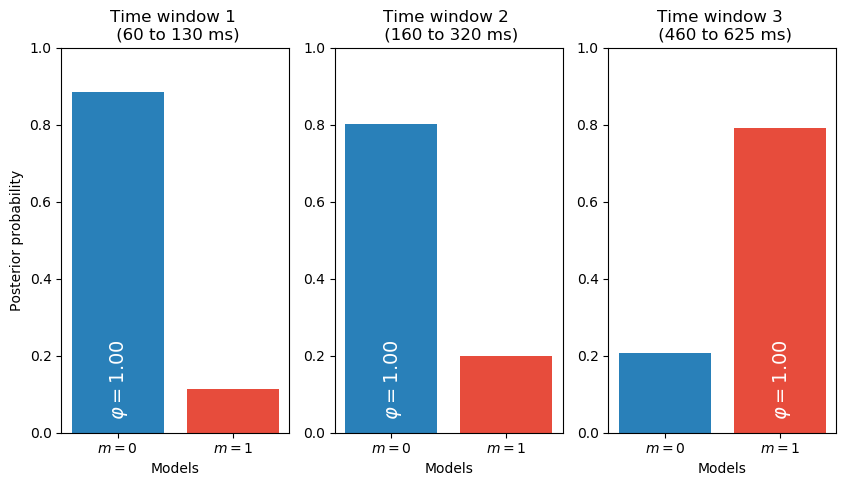

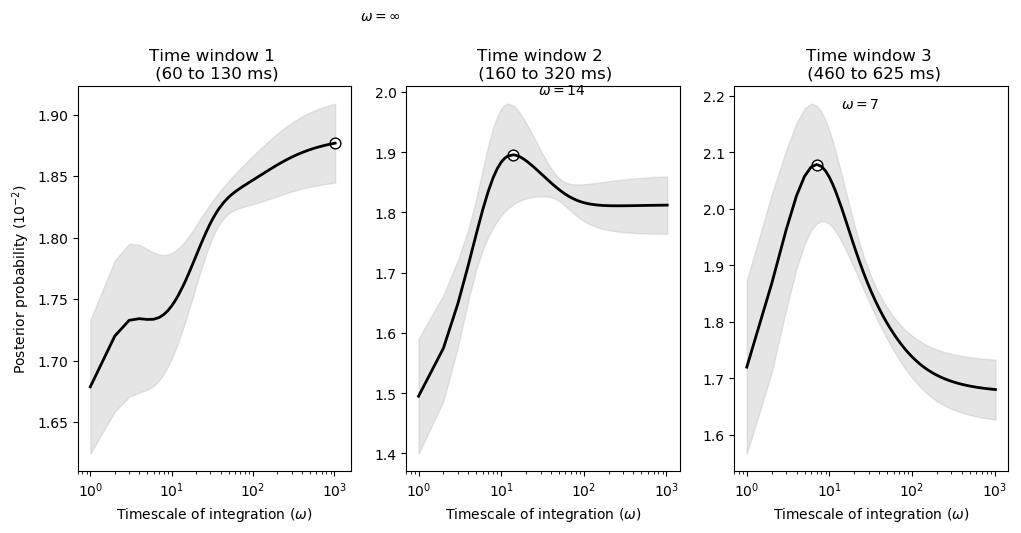



[2020-04-14T19:50:09.741] MODE 9

[2020-04-14T19:50:09.741] Loading data for subject 1...
[2020-04-14T19:50:20.45] Loading data for subject 2...
[2020-04-14T19:50:29.434] Loading data for subject 3...
[2020-04-14T19:50:39.138] Loading data for subject 4...
[2020-04-14T19:50:48.846] Loading data for subject 5...
[2020-04-14T19:50:58.748] Loading data for subject 6...
[2020-04-14T19:51:09.222] Loading data for subject 7...
[2020-04-14T19:51:19.466] Loading data for subject 8...
[2020-04-14T19:51:29.141] Loading data for subject 9...
[2020-04-14T19:51:37.474] Loading data for subject 10...
[2020-04-14T19:51:48.098] Loading data for subject 11...
[2020-04-14T19:51:56.948] Loading data for subject 12...
[2020-04-14T19:52:05.732] Loading data for subject 13...
[2020-04-14T19:52:13.972] Loading data for subject 14...
[2020-04-14T19:52:23.192] Loading data for subject 15...
[2020-04-14T19:52:33.301] Loading data for subject 16...
[2020-04-14T19:52:42.793] Loading data for subject 17...
[2020

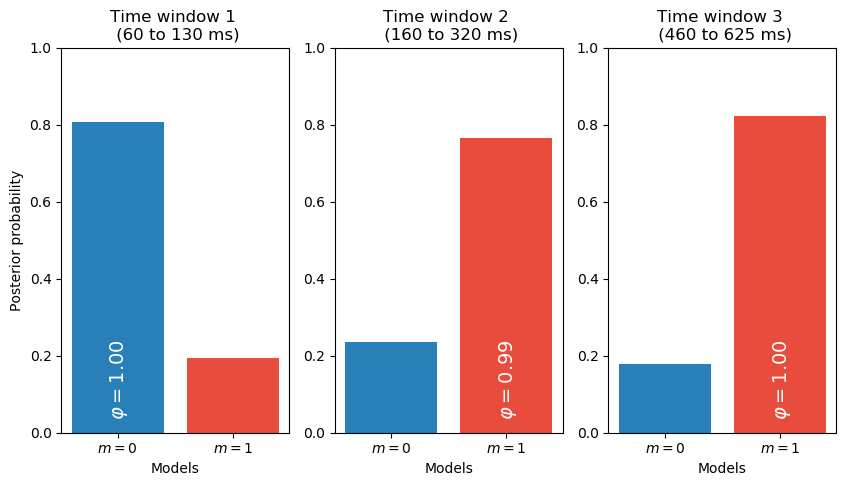

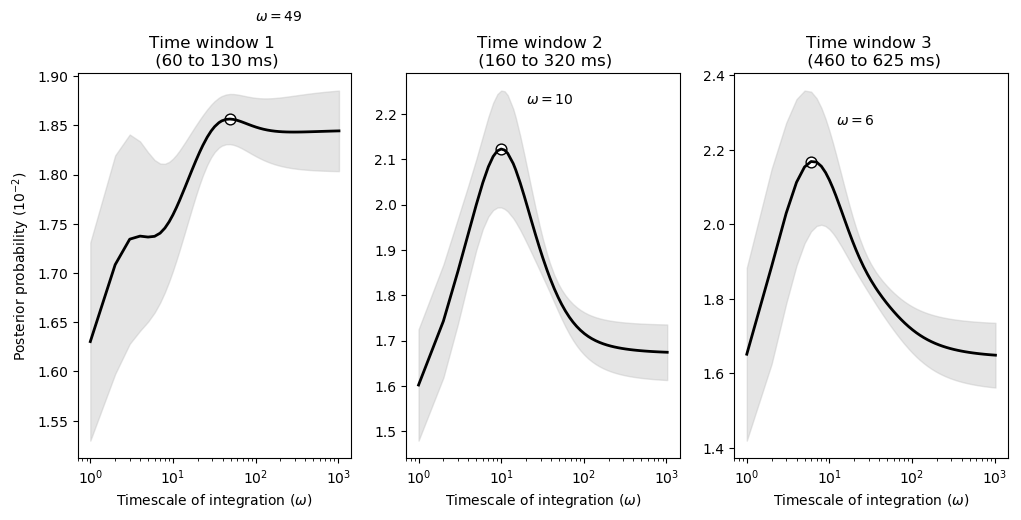



[2020-04-14T19:53:03.345] MODE 10

[2020-04-14T19:53:03.345] Loading data for subject 1...
[2020-04-14T19:53:11.327] Loading data for subject 2...
[2020-04-14T19:53:18.594] Loading data for subject 3...
[2020-04-14T19:53:25.731] Loading data for subject 4...
[2020-04-14T19:53:33.699] Loading data for subject 5...
[2020-04-14T19:53:41.984] Loading data for subject 6...
[2020-04-14T19:53:50.536] Loading data for subject 7...
[2020-04-14T19:53:57.958] Loading data for subject 8...
[2020-04-14T19:54:05.43] Loading data for subject 9...
[2020-04-14T19:54:12.575] Loading data for subject 10...
[2020-04-14T19:54:20.315] Loading data for subject 11...
[2020-04-14T19:54:27.44] Loading data for subject 12...
[2020-04-14T19:54:34.78] Loading data for subject 13...
[2020-04-14T19:54:40.823] Loading data for subject 14...
[2020-04-14T19:54:48.275] Loading data for subject 15...
[2020-04-14T19:54:55.903] Loading data for subject 16...
[2020-04-14T19:55:03.169] Loading data for subject 17...
[2020-

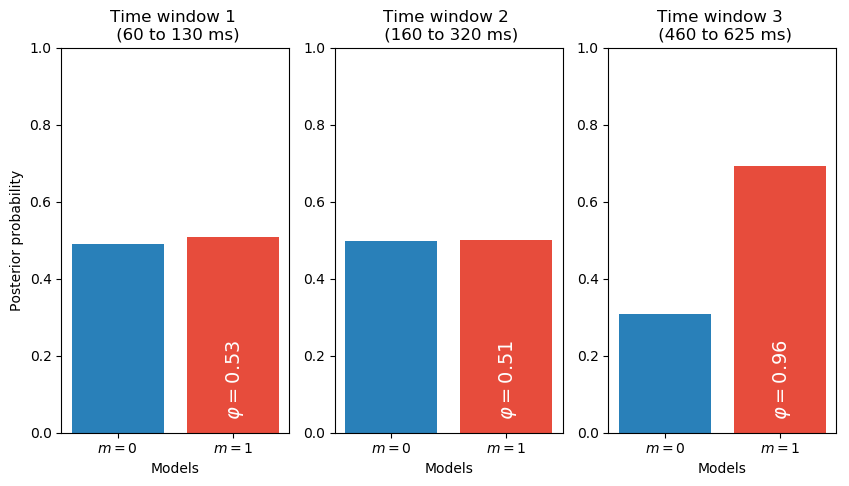

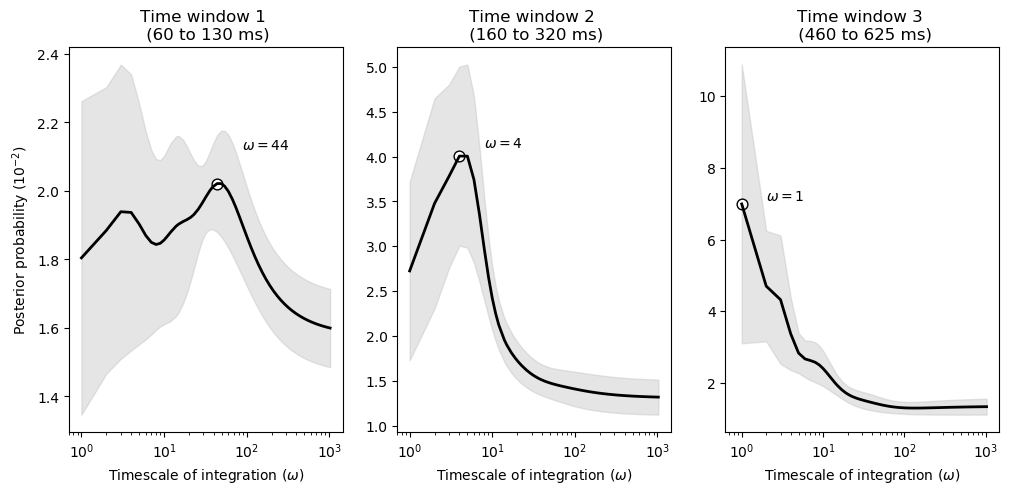

In [47]:
# TRIAL 1b
modes = 6:10;
for mode in modes
    lg("MODE $mode")
    println("")

    wBICs, mBICs = getBICForSubjects(subjects, models, rules, slices, mode, onehotencode_blocks, 1)
    
    fig = fig5D(mBICs, models, sliceNames)
    display(fig)
    clf()
    
    fig = fig5E(ws, wBICs, sliceNames)
    display(fig)
    clf()
    
    println("")
    println("")
end

## Trial 2

[2020-04-14T20:58:28.188] MODE 6

[2020-04-14T20:58:33.682] Loading data for subject 1...
[2020-04-14T21:02:24.981] Loading data for subject 2...
[2020-04-14T21:06:44.63] Loading data for subject 3...
[2020-04-14T21:11:08.426] Loading data for subject 4...
[2020-04-14T21:17:19.614] Loading data for subject 5...
[2020-04-14T21:20:19.966] Loading data for subject 6...
[2020-04-14T21:22:33.453] Loading data for subject 7...
[2020-04-14T21:24:47.623] Loading data for subject 8...
[2020-04-14T21:26:31.61] Loading data for subject 9...
[2020-04-14T21:27:46.446] Loading data for subject 10...
[2020-04-14T21:29:21.792] Loading data for subject 11...
[2020-04-14T21:30:38.853] Loading data for subject 12...
[2020-04-14T21:31:59.308] Loading data for subject 13...
[2020-04-14T21:33:36.383] Loading data for subject 14...
[2020-04-14T21:35:35.751] Loading data for subject 15...
[2020-04-14T21:37:37.863] Loading data for subject 16...
[2020-04-14T21:39:36.059] Loading data for subject 17...
[2020-04

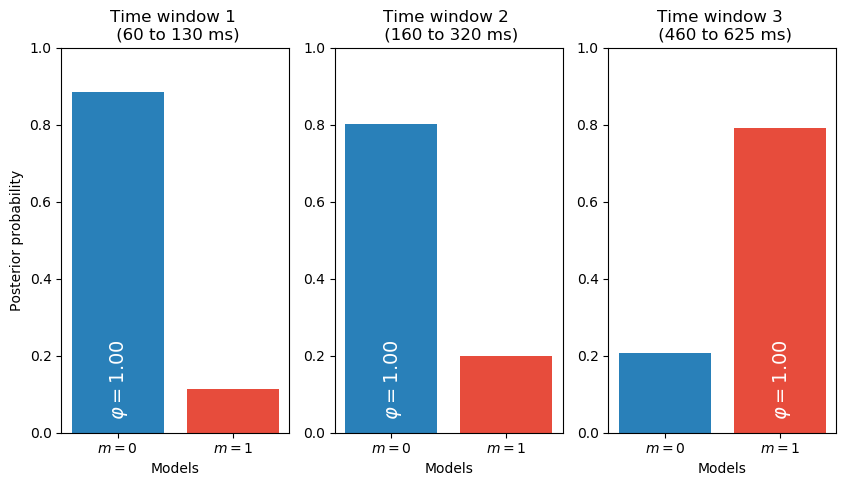

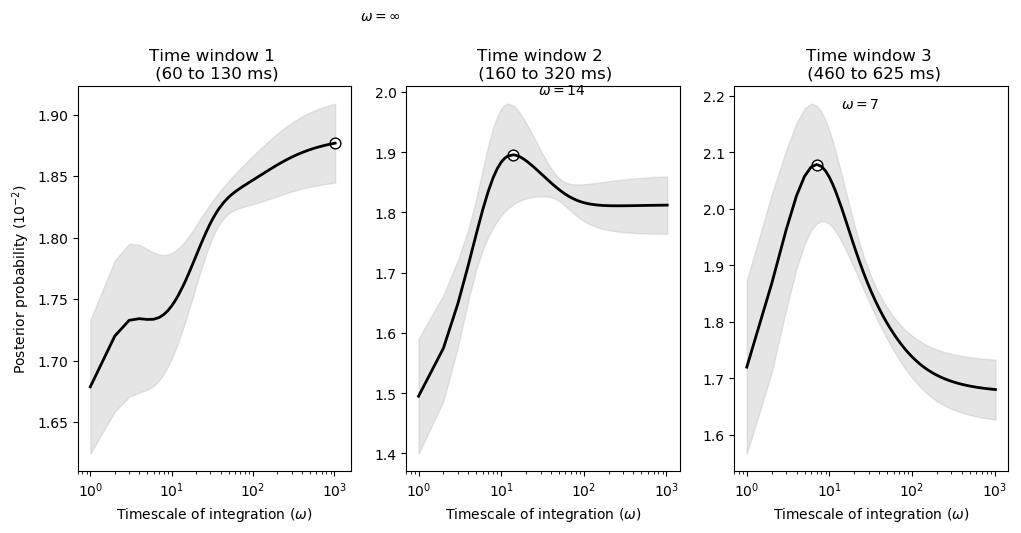



[2020-04-14T21:43:06.62] MODE 7

[2020-04-14T21:43:06.622] Loading data for subject 1...
[2020-04-14T21:45:21.982] Loading data for subject 2...
[2020-04-14T21:46:52.078] Loading data for subject 3...
[2020-04-14T21:48:27.687] Loading data for subject 4...
[2020-04-14T21:50:09.866] Loading data for subject 5...
[2020-04-14T21:52:35.788] Loading data for subject 6...
[2020-04-14T21:55:04.547] Loading data for subject 7...
[2020-04-14T21:57:33.782] Loading data for subject 8...
[2020-04-14T21:59:41.873] Loading data for subject 9...
[2020-04-14T22:01:30.106] Loading data for subject 10...
[2020-04-14T22:03:56.874] Loading data for subject 11...
[2020-04-14T22:05:32.772] Loading data for subject 12...
[2020-04-14T22:07:14.296] Loading data for subject 13...
[2020-04-14T22:08:33.604] Loading data for subject 14...
[2020-04-14T22:09:58.264] Loading data for subject 15...
[2020-04-14T22:11:31.077] Loading data for subject 16...
[2020-04-14T22:12:49.496] Loading data for subject 17...
[2020

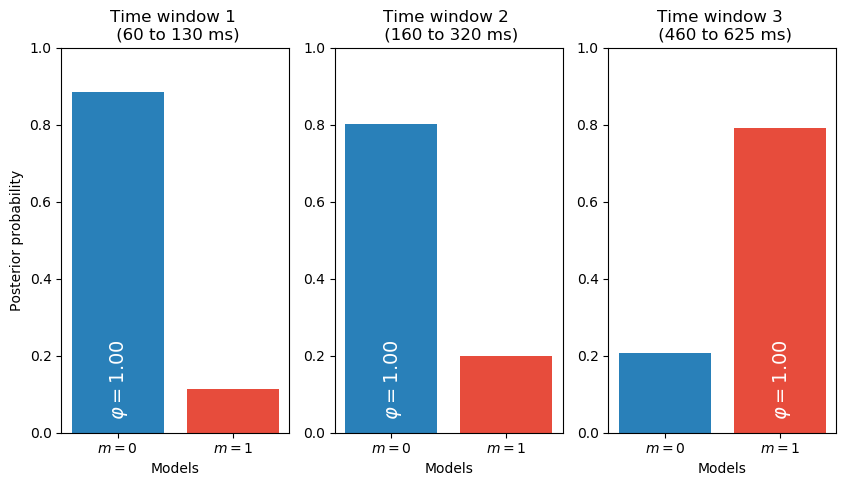

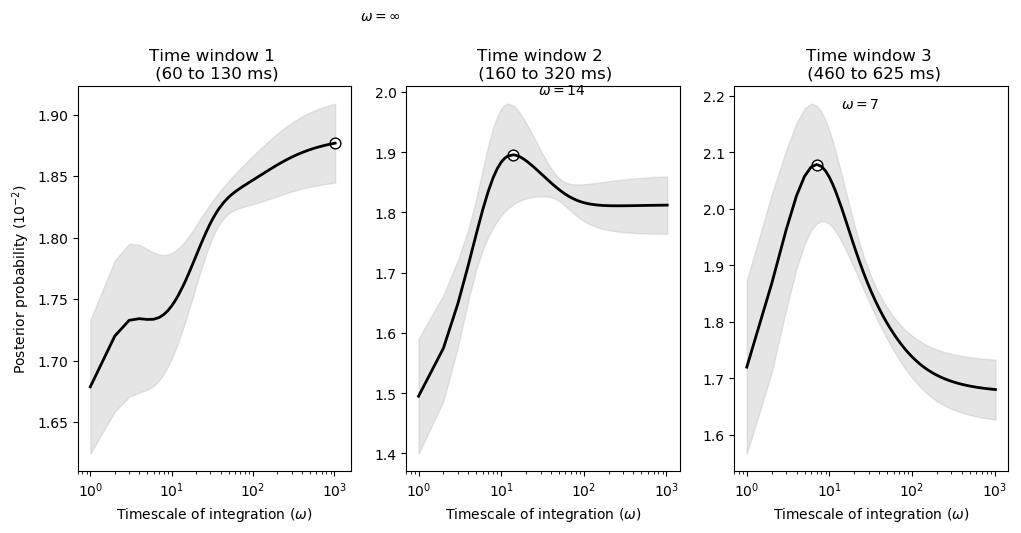



[2020-04-14T22:16:08.21] MODE 8

[2020-04-14T22:16:08.215] Loading data for subject 1...
[2020-04-14T22:18:13.017] Loading data for subject 2...
[2020-04-14T22:20:02.319] Loading data for subject 3...
[2020-04-14T22:22:13.226] Loading data for subject 4...
[2020-04-14T22:24:30.227] Loading data for subject 5...
[2020-04-14T22:27:18.223] Loading data for subject 6...
[2020-04-14T22:30:07.137] Loading data for subject 7...
[2020-04-14T22:32:53.522] Loading data for subject 8...
[2020-04-14T22:35:06.911] Loading data for subject 9...
[2020-04-14T22:37:08.324] Loading data for subject 10...
[2020-04-14T22:39:52.8] Loading data for subject 11...
[2020-04-14T22:41:13.319] Loading data for subject 12...
[2020-04-14T22:42:28.38] Loading data for subject 13...
[2020-04-14T22:43:25.479] Loading data for subject 14...
[2020-04-14T22:44:33.551] Loading data for subject 15...
[2020-04-14T22:45:55.955] Loading data for subject 16...
[2020-04-14T22:47:17.202] Loading data for subject 17...
[2020-04

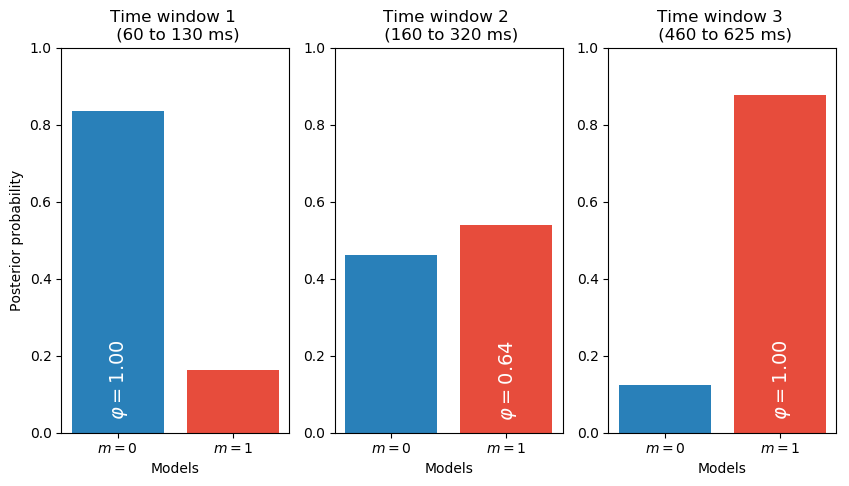

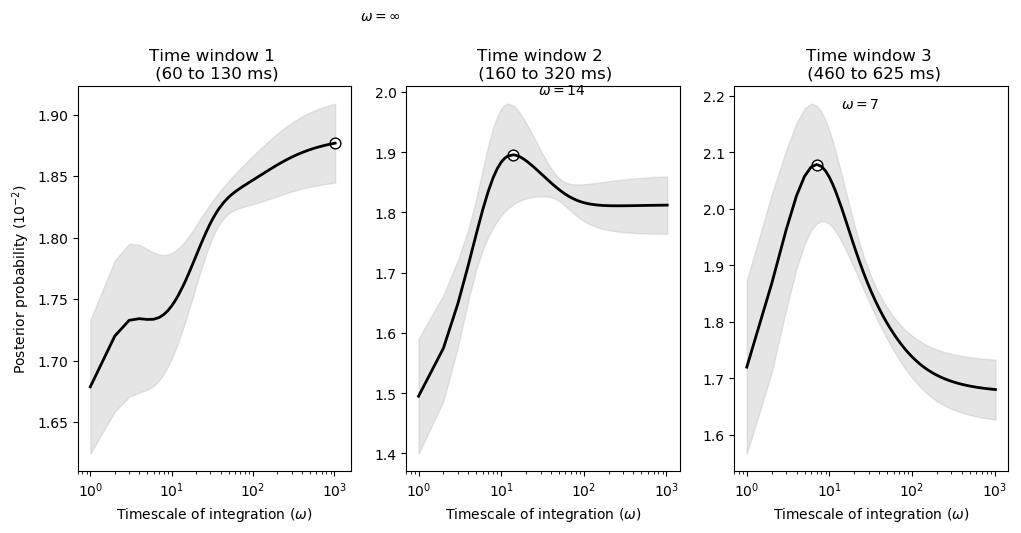



[2020-04-14T22:49:50.569] MODE 9

[2020-04-14T22:49:50.571] Loading data for subject 1...
[2020-04-14T22:50:02.086] Loading data for subject 2...
[2020-04-14T22:50:11.22] Loading data for subject 3...
[2020-04-14T22:50:21.76] Loading data for subject 4...
[2020-04-14T22:50:32.377] Loading data for subject 5...
[2020-04-14T22:50:44.267] Loading data for subject 6...
[2020-04-14T22:50:56.027] Loading data for subject 7...
[2020-04-14T22:51:07.237] Loading data for subject 8...
[2020-04-14T22:51:17.371] Loading data for subject 9...
[2020-04-14T22:51:26.875] Loading data for subject 10...
[2020-04-14T22:51:38.081] Loading data for subject 11...
[2020-04-14T22:51:47.328] Loading data for subject 12...
[2020-04-14T22:51:57.247] Loading data for subject 13...
[2020-04-14T22:52:06.019] Loading data for subject 14...
[2020-04-14T22:52:16.569] Loading data for subject 15...
[2020-04-14T22:52:27.923] Loading data for subject 16...
[2020-04-14T22:52:37.79] Loading data for subject 17...
[2020-0

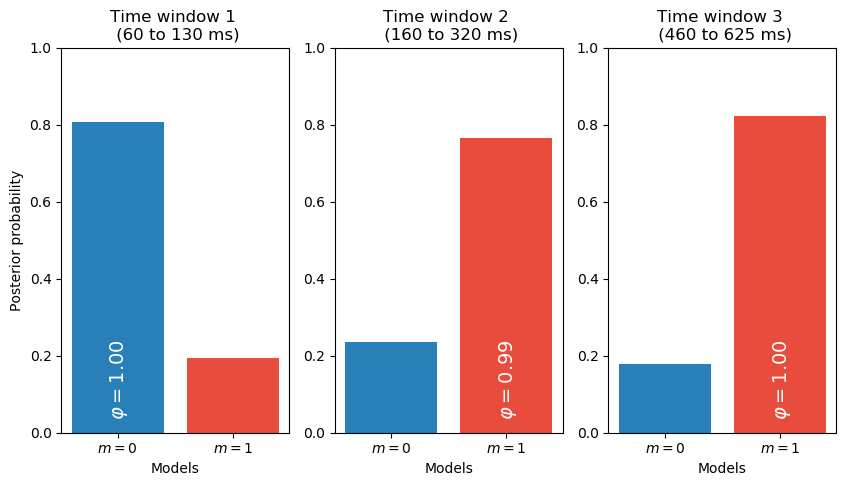

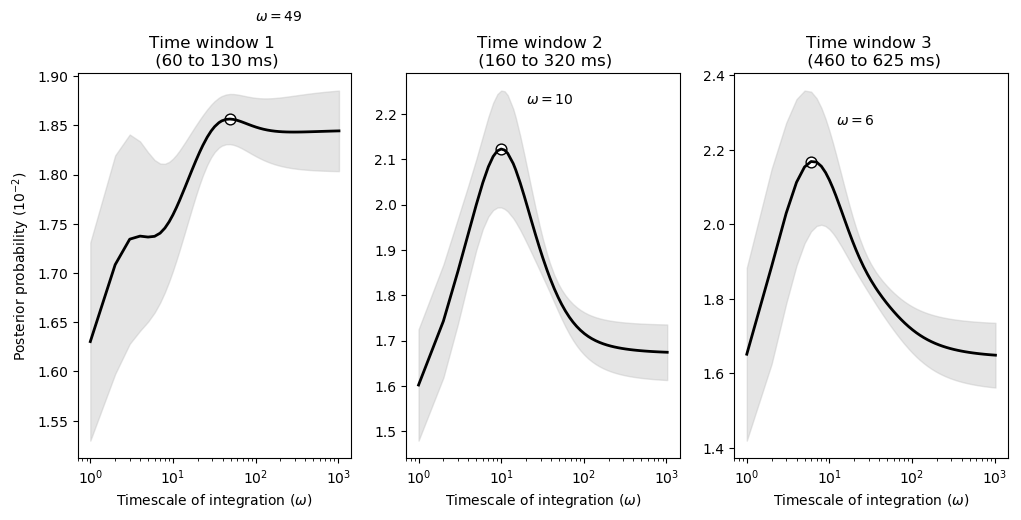



[2020-04-14T22:53:03.853] MODE 10

[2020-04-14T22:53:03.854] Loading data for subject 1...
[2020-04-14T22:53:12.616] Loading data for subject 2...
[2020-04-14T22:53:20.793] Loading data for subject 3...
[2020-04-14T22:53:29.872] Loading data for subject 4...
[2020-04-14T22:53:38.789] Loading data for subject 5...
[2020-04-14T22:53:47.804] Loading data for subject 6...
[2020-04-14T22:53:55.847] Loading data for subject 7...
[2020-04-14T22:54:04.346] Loading data for subject 8...
[2020-04-14T22:54:13.115] Loading data for subject 9...
[2020-04-14T22:54:20.751] Loading data for subject 10...
[2020-04-14T22:54:28.976] Loading data for subject 11...
[2020-04-14T22:54:36.132] Loading data for subject 12...
[2020-04-14T22:54:44.333] Loading data for subject 13...
[2020-04-14T22:54:51.491] Loading data for subject 14...
[2020-04-14T22:54:59.551] Loading data for subject 15...
[2020-04-14T22:55:08.055] Loading data for subject 16...
[2020-04-14T22:55:16.572] Loading data for subject 17...
[20

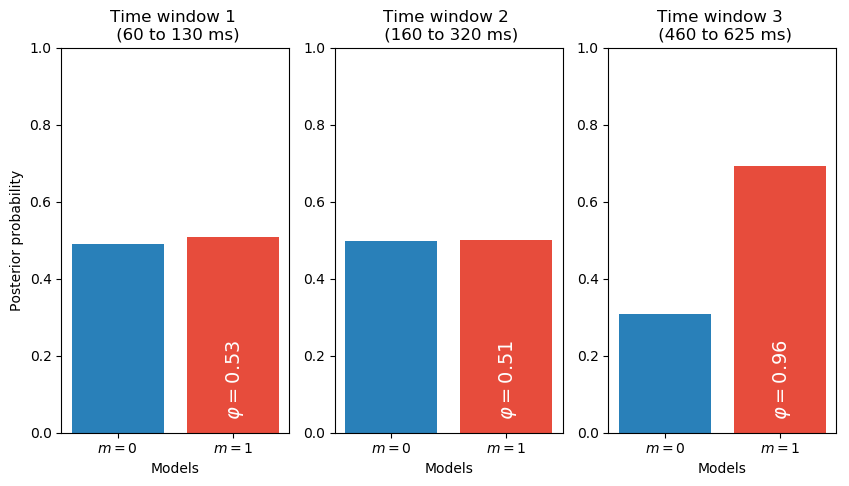

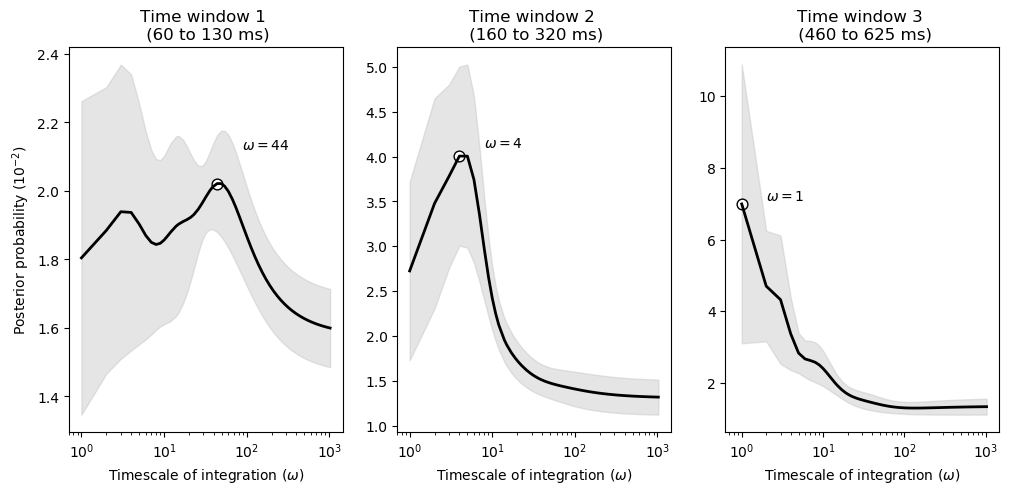

In [21]:
#### TRIAL 2
for mode in modes
    lg("MODE $mode")
    println("")

    wBICs, mBICs = getBICForSubjects(subjects, models, rules, slices, mode, onehotencode_blocks, 1)
    
    fig = fig5D(mBICs, models, sliceNames)
    display(fig)
    clf()
    
    fig = fig5E(ws, wBICs, sliceNames)
    display(fig)
    clf()
    
    println("")
    println("")
end

[2020-04-14T22:56:33.793] MODE 11

[2020-04-14T22:56:33.795] Loading data for subject 1...
[2020-04-14T22:56:43.361] Loading data for subject 2...
[2020-04-14T22:56:51.613] Loading data for subject 3...
[2020-04-14T22:56:59.664] Loading data for subject 4...
[2020-04-14T22:57:08.619] Loading data for subject 5...
[2020-04-14T22:57:18.866] Loading data for subject 6...
[2020-04-14T22:57:27.135] Loading data for subject 7...
[2020-04-14T22:57:36.144] Loading data for subject 8...
[2020-04-14T22:57:43.746] Loading data for subject 9...
[2020-04-14T22:57:50.989] Loading data for subject 10...
[2020-04-14T22:58:00.035] Loading data for subject 11...
[2020-04-14T22:58:06.91] Loading data for subject 12...
[2020-04-14T22:58:14.458] Loading data for subject 13...
[2020-04-14T22:58:21.138] Loading data for subject 14...
[2020-04-14T22:58:28.991] Loading data for subject 15...
[2020-04-14T22:58:37.67] Loading data for subject 16...
[2020-04-14T22:58:46.197] Loading data for subject 17...
[2020-0

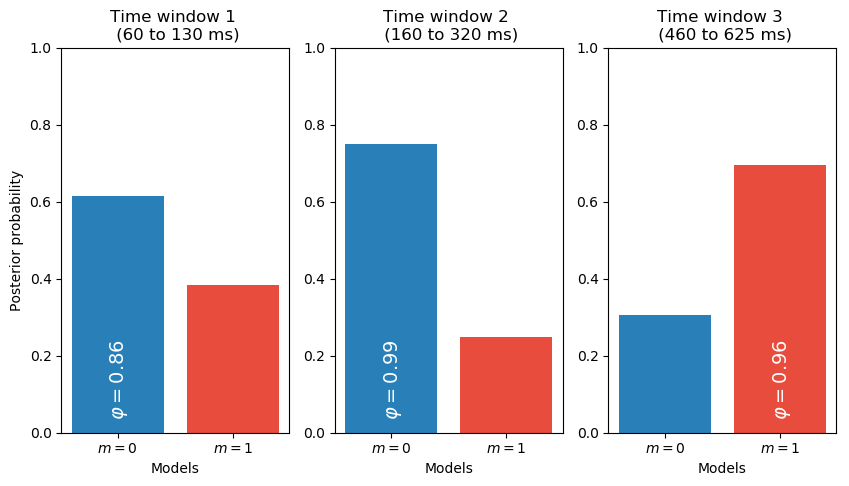

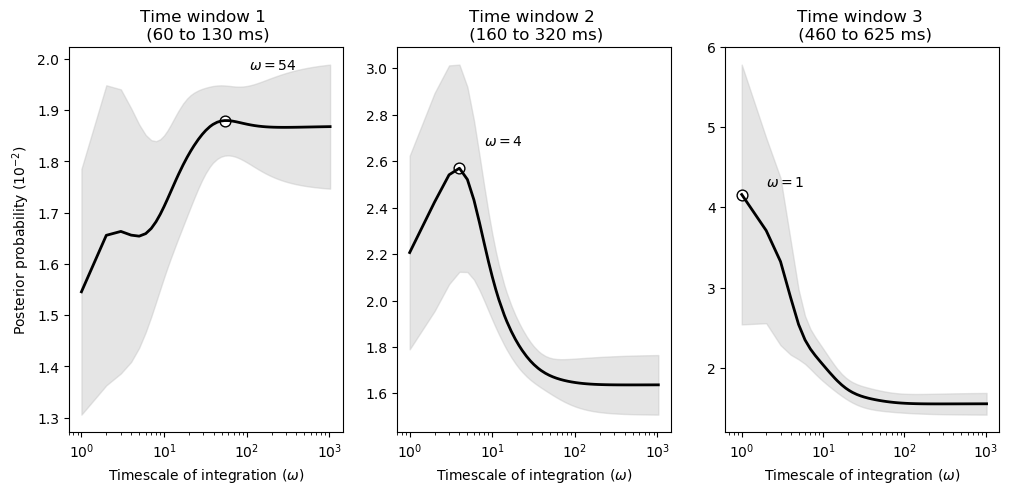



[2020-04-14T22:59:02.62] MODE 12

[2020-04-14T22:59:02.622] Loading data for subject 1...
[2020-04-14T23:00:41.541] Loading data for subject 2...


In [ ]:
#### TRIAL 2b
modes = 11:12
for mode in modes
    lg("MODE $mode")
    println("")

    wBICs, mBICs = getBICForSubjects(subjects, models, rules, slices, mode, onehotencode_blocks, 1)
    
    fig = fig5D(mBICs, models, sliceNames)
    display(fig)
    clf()
    
    fig = fig5E(ws, wBICs, sliceNames)
    display(fig)
    clf()
    
    println("")
    println("")
end

[2020-04-15T12:53:58.226] MODE 12

[2020-04-15T12:54:11.86] Loading data for subject 1...
[2020-04-15T13:02:20.661] Loading data for subject 2...
[2020-04-15T13:10:22.71] Loading data for subject 3...
[2020-04-15T13:19:18.672] Loading data for subject 4...
[2020-04-15T13:28:53.381] Loading data for subject 5...
[2020-04-15T13:32:30.388] Loading data for subject 6...
[2020-04-15T13:35:02.256] Loading data for subject 7...
[2020-04-15T13:37:41.195] Loading data for subject 8...
[2020-04-15T13:39:51.48] Loading data for subject 9...
[2020-04-15T13:41:47.817] Loading data for subject 10...
[2020-04-15T13:44:34.802] Loading data for subject 11...
[2020-04-15T13:46:32.25] Loading data for subject 12...
[2020-04-15T13:48:40.446] Loading data for subject 13...
[2020-04-15T13:50:29.645] Loading data for subject 14...
[2020-04-15T13:52:33.515] Loading data for subject 15...
[2020-04-15T13:54:46.965] Loading data for subject 16...
[2020-04-15T13:56:55.587] Loading data for subject 17...
[2020-04-

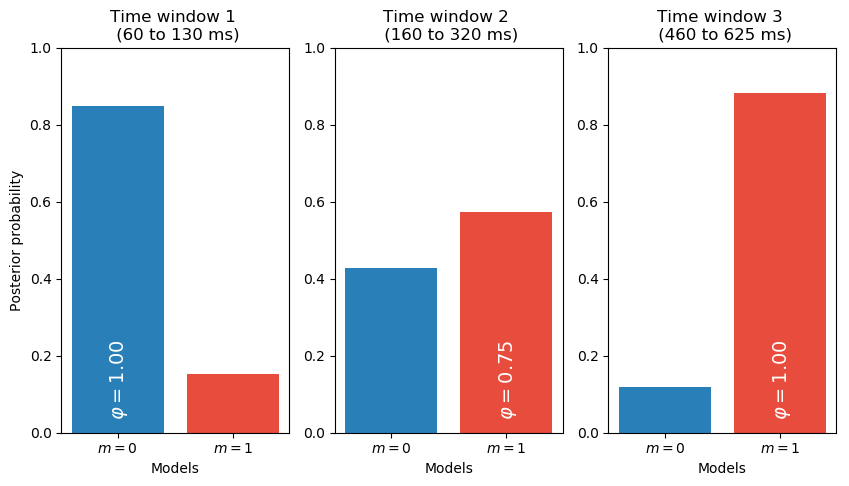

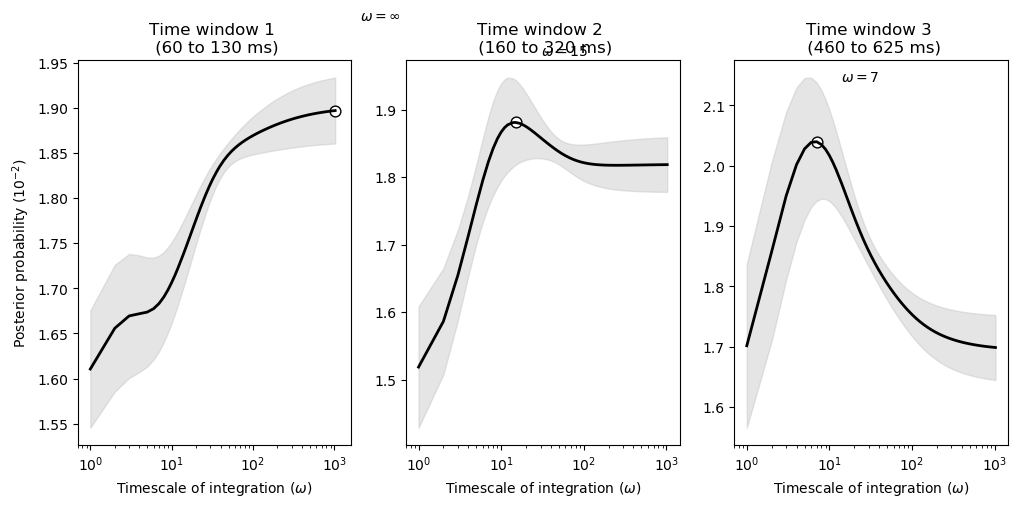

In [20]:
#### TRIAL 2c
modes = [12]
for mode in modes
    lg("MODE $mode")
    println("")

    wBICs, mBICs = getBICForSubjects(subjects, models, rules, slices, mode, onehotencode_blocks, 1)
    
    fig = fig5D(mBICs, models, sliceNames)
    display(fig)
    clf()
    
    fig = fig5E(ws, wBICs, sliceNames)
    display(fig)
    clf()
    
    println("")
    println("")
end